## Imports

In [75]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt

## Settings

In [76]:
imdir = '/home/drevital/obstacles_classification_datasets/rgb_6/train/obstacle'
imname = '1_204_1.00_2021-08-17--18-15-29_.jpg'
threshold = 55
threshold_decrement = 1
min_white_percent = .05

# Read image & separate it to <ref, current>

In [77]:
imrgb = cv2.imread(os.path.join(imdir, imname))
im = cv2.cvtColor(imrgb, cv2.COLOR_BGR2RGB) 
h = im.shape[0]
w = im.shape[1]
ref = im[:, :w//2, 1]
current = im[:, w//2:, 1]
pixels = h * w

## Generate diff & mask images

In [78]:
diff = cv2.absdiff(current, ref)

# Loop to generate mask, with threshold decrements, until receving a non-zero mask
while True:
    _, mask = cv2.threshold(diff, threshold, 255, cv2.THRESH_BINARY)

    # Pad the contoured image with zeros, to enable the kernel be applied on edges
    mask_pad = np.zeros((mask.shape[0]+100, mask.shape[1]+100), np.uint8)
    x1 = (mask_pad.shape[0] - mask.shape[0]) // 2
    x2 = x1 + mask.shape[0]
    y1 = (mask_pad.shape[1] - mask.shape[1]) // 2
    y2 = y1 + mask.shape[1]
    mask_pad[x1:x2, y1:y2] = mask

    # old morphological operations
    copyImg = cv2.erode(mask_pad, np.ones((3, 3), np.uint8), iterations=1)  # reduce noise
    copyImg = cv2.dilate(copyImg, np.ones((7, 7), np.uint8), iterations=1)
    copyImg = cv2.erode(copyImg, np.ones((5, 5), np.uint8), iterations=1)
    copyImg = cv2.dilate(copyImg, np.ones((9, 9), np.uint8), iterations=1)
    kernel = np.ones((11, 11), np.uint8)  # kernel for dilation

    # increase area to an object
    copyImg = cv2.dilate(copyImg, kernel, iterations=2)
    copyImg = cv2.dilate(copyImg, np.ones((13, 13), np.uint8), iterations=1)
    copyImg = cv2.erode(copyImg, np.ones((11, 11), np.uint8), iterations=1)
    copyImg = cv2.erode(copyImg, np.ones((5, 5), np.uint8), iterations=1)
    mask_pad = copyImg

    # Return to original countoured image dimensions
    mask = mask_pad[x1:x2, y1:y2]

    if (np.sum(mask)//255) / pixels > min_white_percent:
        break
        
    threshold -= threshold_decrement

## Concatenate <ref, current, mask> for training

In [79]:
concat = cv2.hconcat([ref, current, mask])

## Display concatenated image

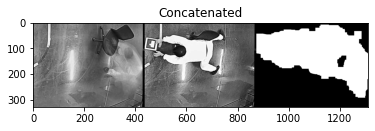

In [80]:
plt.imshow(concat, cmap='gray', vmin=0, vmax=255)
plt.title('Concatenated')
plt.show()

In [81]:
cv2.imwrite('./im/' + imname + '_current_morph_.jpg', concat)

True